# Data Pre-processing for ATMS 523 Final Project
### Author: Domenic Brooks

# Objective
The purpose of this project is to investigate the relationship between teleconnection patterns and winter snowfall totals for a given city. The goal of this project is to produce a tool to run an ML model to predict the amount of snowfall based on the given teleconnections. 

# Data
For snowfall, the dataset used is ERA-5 reanalysis. While perhaps not the most accurate or precise for snowfall records, it does provide a continous gridded dataset for a period of record dating back to 1940, which is essential for gathering enough seasons for the ML model training. 

For teleconnections, the NOAA Climate Prediction Center (CPC) and NCEI provide tabular datasets for monthly indices dating back to 1950 for various teleconnections, the ones which will be used in this project are:

- El Nino Southern Oscillation (ENSO)
- North Atlantic Oscillation (NAO)
- Arctic Osciallation (AO)
- Pacific North American Oscillation (PNA)
- Pacific Decadal Oscillation (PDO)
- Indian Ocean Dipole (IOD)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import scipy.stats as stats
import cartopy.feature as cfeature
import cartopy.crs as ccrs 

# Teleconnection Dataset Processing

In [2]:
# ENSO
enso = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.el_nino.dat',
                   sep=r'\s+', header=None, skiprows=0, engine='python')
# Grab ENSO 3.4 values and reformat for proper merging later                   
enso = enso[[0,1,4]].pivot_table(values=4, index=0, columns=1).reset_index()

# NAO
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table',
                  sep=r'\s+', header=None, skiprows=1, engine='python')

# AO
ao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table',
                  sep=r'\s+', header=None, skiprows=1, engine='python')

# PNA
pna = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.pna.monthly.b5001.current.ascii.table',
                  sep=r'\s+', header=None, skiprows=1, engine='python')  

# PDO
pdo = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat',
                  sep=r'\s+', header=None, skiprows=2, engine='python')

# IOD
iod = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.iod.dat',
                  sep=r'\s+', header=None, skiprows=1, engine='python')
# Grab difference values and reformat for proper merging later              
iod = iod[[0,1,4]].pivot_table(values=4, index=0, columns=1).reset_index()

In [3]:
###### Create merged dataframe for all indices #######

enso_new=pd.DataFrame()
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()
pna_new=pd.DataFrame()
iod_new=pd.DataFrame()

# Create monthly date intervals
enso_new['Date'] = pd.date_range(start=datetime.datetime(enso[0].iloc[0],1,1),end=datetime.datetime(enso[0].iloc[-1],12,1),freq="MS")
nao_new['Date'] = pd.date_range(start=datetime.datetime(nao[0].iloc[0],1,1),end=datetime.datetime(nao[0].iloc[-1],12,1),freq="MS")
pdo_new['Date'] = pd.date_range(start=datetime.datetime(pdo[0].iloc[0],1,1),end=datetime.datetime(pdo[0].iloc[-1],12,1),freq="MS")
ao_new['Date'] = pd.date_range(start=datetime.datetime(ao[0].iloc[0],1,1),end=datetime.datetime(ao[0].iloc[-1],12,1),freq="MS")
pna_new['Date'] = pd.date_range(start=datetime.datetime(pna[0].iloc[0],1,1),end=datetime.datetime(pna[0].iloc[-1],12,1),freq="MS")
iod_new['Date'] = pd.date_range(start=datetime.datetime(iod[0].iloc[0],1,1),end=datetime.datetime(iod[0].iloc[-1],12,1),freq="MS")

# Set the monthly timesteps to the index
enso_new = enso_new.set_index('Date')
nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')
pna_new = pna_new.set_index('Date')
iod_new = iod_new.set_index('Date')

# Add teleconnection indices to date index
enso_new['ENSO']=enso.loc[:,1:].stack(dropna=False).values
nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
ao_new['AO']=ao.loc[:,1:].stack(dropna=False).values
pna_new['PNA']=pna.loc[:,1:].stack(dropna=False).values
iod_new['IOD']=iod.loc[:,1:].stack(dropna=False).values

# Merge all dataframes and also account for missnig value markers
newdf_all = pd.merge(enso_new,pdo_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['PDO'] >= 99.,'PDO'] = np.nan
newdf_all.loc[newdf_all['ENSO'] <= -99.9,'ENSO'] = np.nan
newdf_all = pd.merge(newdf_all,nao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['NAO'] <= -99.9,'NAO'] = np.nan
newdf_all = pd.merge(newdf_all,ao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['AO'] <= -99.9,'AO'] = np.nan
newdf_all = pd.merge(newdf_all,pna_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['PNA'] <= -99.9,'PNA'] = np.nan
newdf_all = pd.merge(newdf_all,iod_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['IOD'] <= -99.9,'IOD'] = np.nan

# Resample to seasonal means
#newdf_all = newdf_all.resample('QS-DEC', closed='left', label='left').mean()

newdf_all

/tmp/ipykernel_1346067/2434704326.py:27: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  enso_new['ENSO']=enso.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_1346067/2434704326.py:28: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_1346067/2434704326.py:29: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this

,ENSO,PDO,NAO,AO,PNA,IOD
Date,,,,,,
1950-01-01,-2.04,-1.61,0.92,-0.060,-2.34,-0.01
1950-02-01,-1.72,-2.17,0.40,0.627,-1.04,-0.51
1950-03-01,-1.38,-1.89,-0.36,-0.008,0.24,-0.29
1950-04-01,-1.41,-1.99,0.73,0.555,0.01,-0.12
1950-05-01,-1.62,-3.19,-0.59,0.072,-0.55,-0.09
...,...,...,...,...,...,...
2025-08-01,-0.32,-3.19,0.26,0.036,-0.36,-0.45
2025-09-01,-0.50,-2.31,-0.80,0.048,0.81,-0.57
2025-10-01,-0.48,-2.36,-0.96,0.064,1.42,-0.83


# ERA-5 data retrieval

In [4]:
# Start dask client
from dask.distributed import Client
client = Client() 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 256,Total memory: 502.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38281,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45239,Total threads: 16
Dashboard: http://127.0.0.1:38743/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:37375,


In [5]:
# Load full ERA-5 datast
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={"time": 30},
    storage_options=dict(token='anon'),
)
ds

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * time                                                             (time) datetime64[ns] 11MB ...
  * latitude                                                         (latitude) float32 3kB ...
  * longitude                                                        (longitude) float32 6kB ...
  * level                                                            (level) int64 296B ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 5TB dask.array<chunksize=(30, 721, 1440), meta=np.ndarray>
Attributes:
    last_updated:           2025-12-08 02:08:54.302123+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-08-31
    valid_time_stop_era5t:  2025-12-02

In [6]:
# Function for selecting city data
def get_era5_data_for_city(ds, var, city_lon, city_lat, start_time, end_time):
    """
    This function serves to grab ERA-5 data for a given variable
    for a given city for a given timeframe.

    Inputs:
    - ds (xarray.Dataset): ERA-5 dataset with all the variables.
    - var (str): Variable you want to grab from the data.
    - city_lon (float): Longitude of selected city.
    - city_lat (float): Latitude of selected city.
    - start time (str): Desired start time (yyyy-mm-dd HH:MM)
    - end time (str): Desired end time (yyyy-mm-dd HH:MM)

    Returns:
    - ds2 (xarray.DataArray): A DataArray containing the data for grid point.
    """

    ds2 = ds[var].sel(
        latitude=city_lat,
        longitude=city_lon+360,
        method='nearest'
    )

    ds2 = ds2.sel(time=slice(start_time, end_time))

    return ds2

var = 'snowfall'
#city_lon, city_lat = -76.609484,39.289221 # Baltimore, MD
city_lon, city_lat = -119.707428,37.714845 # Yosemite
start_time, end_time = '1950-09-01 01:00','2025-02-28 23:00'

# Run function
city_ds = get_era5_data_for_city(
    ds, var, city_lon, city_lat, start_time, end_time)

In [7]:
# Loading into memory takes ~4 min
city_ds = city_ds.compute()
city_ds = city_ds * 1000 # m to mm
print(city_ds)

<xarray.DataArray 'snowfall' (time: 653039)> Size: 3MB
array([ 0.000000e+00,  0.000000e+00,  0.000000e+00, ..., -4.656613e-07,
       -4.656613e-07, -4.656613e-07], shape=(653039,), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 5MB 1950-09-01T01:00:00 ... 2025-02-28T2...
    latitude   float32 4B 37.75
    longitude  float32 4B 240.2
Attributes:
    long_name:      Snowfall
    short_name:     sf
    standard_name:  lwe_thickness_of_snowfall_amount
    units:          m of water equivalent


In [19]:
#city_ds.to_netcdf('Baltimore_snowfall.nc', engine='h5netcdf')
df_djf = xr.open_dataarray('Baltimore_snowfall.nc', engine='h5netcdf')

# Format and merge dataframes

In [42]:
# Turn array into dataframe, and resample to seasonal totals
snow_ds = city_ds.to_dataframe().drop(['latitude','longitude'], axis=1)
#snow_ds = snow_ds.resample('QS-DEC', closed='left', label='left').sum()
snow_ds = snow_ds.resample('MS', closed='left', label='left').sum()
snow_ds.index.name = 'Date'

# Keep only monthly totals from select month
snow_ds = snow_ds[snow_ds.index.month.isin([3])].copy()
snow_ds

,snowfall
Date,
1951-03-01,81.097710
1952-03-01,274.850311
1953-03-01,103.349754
1954-03-01,228.587631
1955-03-01,15.420892
...,...
2020-03-01,147.605530
2021-03-01,61.856350
2022-03-01,29.062050


In [43]:
from scipy import signal
# Detrend the data
snow_ds_detrended = signal.detrend(snow_ds['snowfall'].values)
snow_ds['snowfall_detrended'] = snow_ds_detrended
snow_ds['snowfall_detrended']

Date
1951-03-01    -35.556946
1952-03-01    158.173416
1953-03-01    -13.349388
1954-03-01    111.866249
1955-03-01   -101.322731
                 ...    
2020-03-01     29.416237
2021-03-01    -56.355190
2022-03-01    -89.171730
2023-03-01    196.391479
2024-03-01     83.610367
Freq: 12MS, Name: snowfall_detrended, Length: 74, dtype: float32

In [44]:
# Get winter snowfall mean for 1981-2010
mean_djf_snow = snow_ds['snowfall_detrended']['1981-12-01':'2010-12-01'].mean()
mean_djf_snow

# Get Anomaly 
snow_anom = snow_ds['snowfall_detrended'] - mean_djf_snow

# Standardize the anoms
# Compute long term mean and std
mean = snow_anom.mean()
std = snow_anom.std()

# Avoid division by zero
#std = std.where(std != 0)

# Standardize (subtract mean and divide by std)
snow_standard = (snow_anom - mean) / std
snow_standard

Date
1951-03-01   -0.409630
1952-03-01    1.822217
1953-03-01   -0.153790
1954-03-01    1.288741
1955-03-01   -1.167276
                ...   
2020-03-01    0.338886
2021-03-01   -0.649233
2022-03-01   -1.027292
2023-03-01    2.262504
2024-03-01    0.963223
Freq: 12MS, Name: snowfall_detrended, Length: 74, dtype: float32

In [46]:
# Merge dataframes
df_full = newdf_all.merge(snow_standard, how='outer', on='Date')

# Keep only n month for teleconnections
# and m month for snowfall
df_full = df_full[df_full.index.month.isin([2,3])].copy()
df_full = df_full.iloc[1:-2]

# Shift winter snowfall anoms up by one row to match with previous month indices
df_full['djf_snow_anom'] = df_full['snowfall_detrended'].shift(-1)
df_full = df_full.drop('snowfall_detrended', axis=1).dropna(axis=0)

df_full

,ENSO,PDO,NAO,AO,PNA,IOD,djf_snow_anom
Date,,,,,,,
1951-02-01,-1.07,-1.52,0.70,-0.400,-1.36,0.28,-0.409630
1952-02-01,-0.04,-1.35,-0.83,-1.747,0.28,0.16,1.822217
1953-02-01,0.21,-0.46,-0.49,-0.249,1.00,0.40,-0.153790
1954-02-01,0.24,-0.95,0.74,-0.181,-0.14,0.04,1.288741
1955-02-01,-0.97,-1.01,-1.12,-1.542,-1.74,-0.47,-1.167276
...,...,...,...,...,...,...,...
2020-02-01,0.33,-1.48,1.26,3.417,0.17,-0.27,0.338886
2021-02-01,-1.04,-1.09,0.14,-1.191,-0.31,0.13,-0.649233
2022-02-01,-0.92,-1.91,1.68,1.544,0.66,-0.38,-1.027292


# Some EDA with Correlation and Pair plots

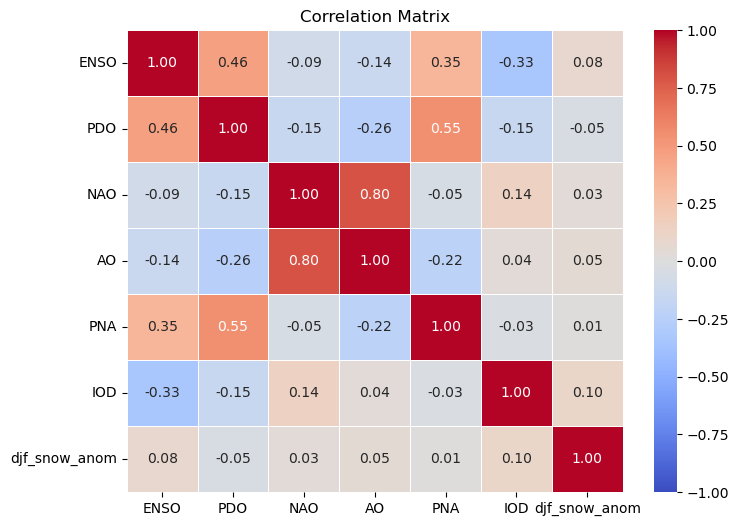

<Figure size 500x500 with 0 Axes>

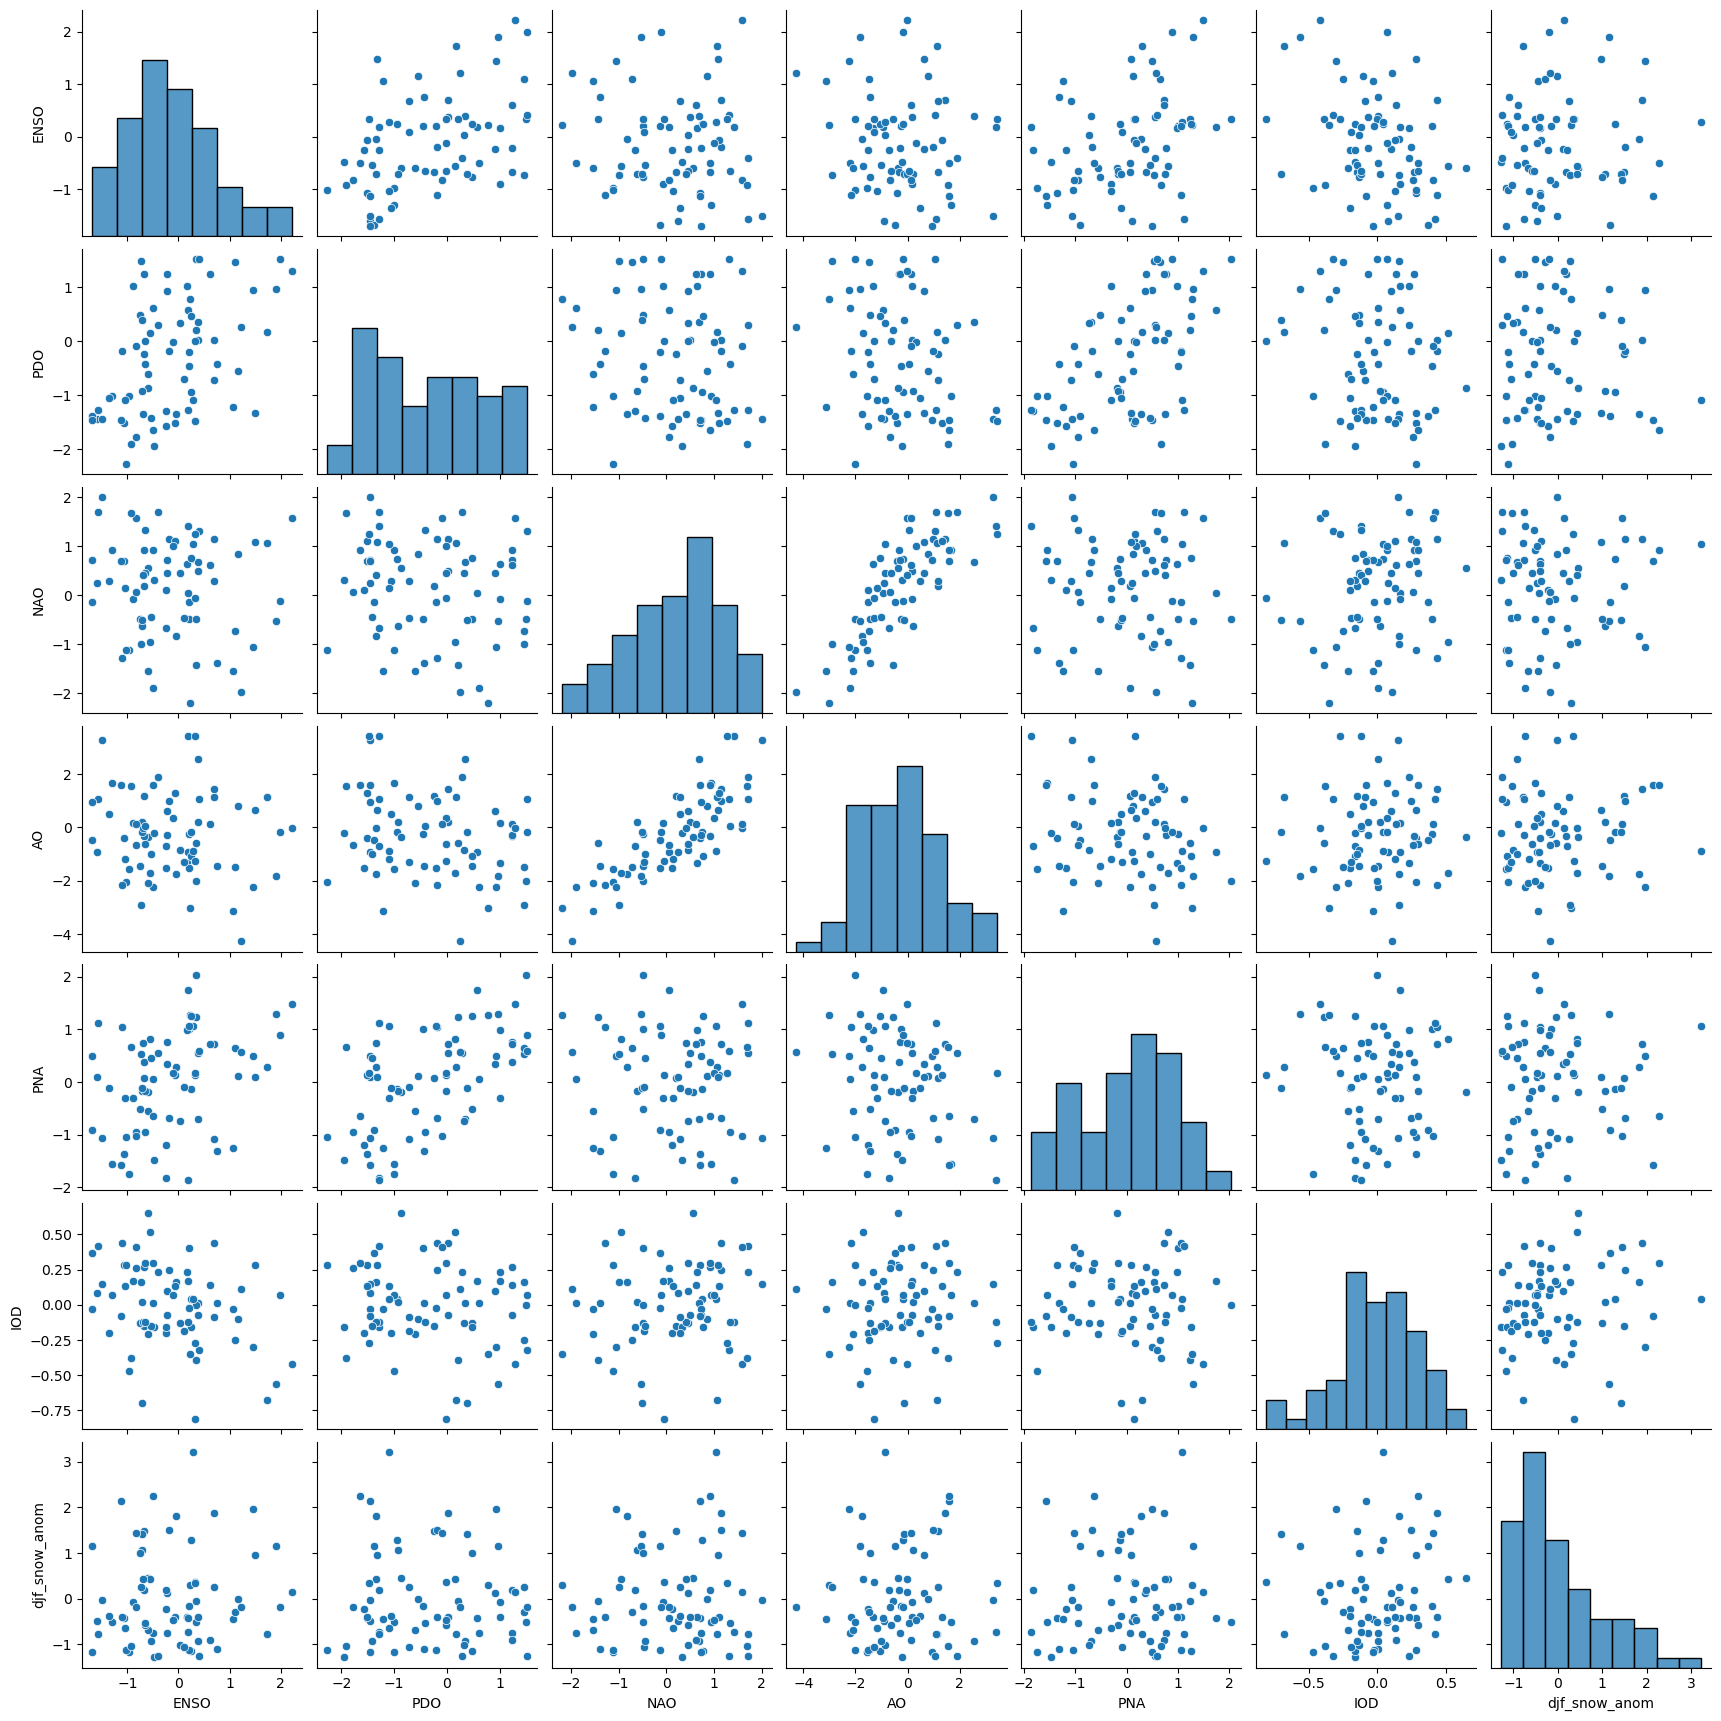

In [47]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_full.corr(), cmap='coolwarm', annot=True, 
            fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# Create pairplot
plt.figure(figsize=(5, 5))
sns.pairplot(df_full)
plt.show()

# Test different models

In [40]:

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Crucial: deterministic small-dataset behavior
RANDOM_STATE = 42

# -----------------------------------------------------
# Load your dataframe (assumes Date index already parsed)
# -----------------------------------------------------
df = df_full.sort_index()

X = df[['ENSO','PDO','NAO','AO','PNA','IOD']]
y = df['djf_snow_anom']

# -----------------------------------------------------
# Time-series CV (prevents leakage)
# -----------------------------------------------------
tscv = TimeSeriesSplit(n_splits=10)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Grid search
rf_params = {
    "n_estimators": [300, 500, 800],
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3]
}

gb_params = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4]
}

xgb_params = {
        "n_estimators": [400, 600, 800],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4],
        "subsample": [0.8, 0.9, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }

# -----------------------------------------------------
# Helper to compute RMSE from CV
# -----------------------------------------------------
from sklearn.model_selection import cross_val_score

def cv_rmse(model):
    scores = cross_val_score(model, X, y, cv=tscv, scoring=rmse_scorer)
    return -np.mean(scores)

# -----------------------------------------------------
# Run Grid Searches
# -----------------------------------------------------
results = {}

# ---- RandomForest ----
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf_grid = GridSearchCV(
    rf,
    rf_params,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)
rf_grid.fit(X, y)

rf_best = rf_grid.best_estimator_
results["RandomForest"] = {
    "best_params": rf_grid.best_params_,
    "best_r2": rf_grid.best_score_,
    "best_rmse": cv_rmse(rf_best),
    "model": rf_best
}

# ---- GradientBoosting ----
gb = GradientBoostingRegressor(random_state=RANDOM_STATE)
gb_grid = GridSearchCV(
    gb,
    gb_params,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)
gb_grid.fit(X, y)

gb_best = gb_grid.best_estimator_
results["GradientBoosting"] = {
    "best_params": gb_grid.best_params_,
    "best_r2": gb_grid.best_score_,
    "best_rmse": cv_rmse(gb_best),
    "model": gb_best
}

# ---- XGBoost (if available) ----

xgb = XGBRegressor(random_state=RANDOM_STATE, objective='reg:squarederror')
xgb_grid = GridSearchCV(
    xgb,
    xgb_params,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)
xgb_grid.fit(X, y)

xgb_best = xgb_grid.best_estimator_
results["XGBoost"] = {
    "best_params": xgb_grid.best_params_,
    "best_r2": xgb_grid.best_score_,
    "best_rmse": cv_rmse(xgb_best),
    "model": xgb_best
}

# -----------------------------------------------------
# Display results
# -----------------------------------------------------
print("\n=== BEST MODELS (after GridSearchCV) ===")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Best R2:   {res['best_r2']:.3f}")
    print(f"  Best RMSE: {res['best_rmse']:.3f}")
    print(f"  Params:    {res['best_params']}")

# -----------------------------------------------------
# Pick global best model
# -----------------------------------------------------
best_name = max(results, key=lambda k: results[k]["best_r2"])
best_model = results[best_name]["model"]

print(f"\n=== GLOBAL BEST MODEL: {best_name} ===")

# -----------------------------------------------------
# Fit global best model to full dataset
# -----------------------------------------------------
best_model.fit(X, y)

# -----------------------------------------------------
# Feature importances
# -----------------------------------------------------
if hasattr(best_model, "feature_importances_"):
    print("\nFeature Importances:")
    for feat, val in zip(X.columns, best_model.feature_importances_):
        print(f"{feat}: {val:.3f}")
else:
    print("\nModel does not expose feature importances.")



=== BEST MODELS (after GridSearchCV) ===

RandomForest:
  Best R2:   -0.233
  Best RMSE: 0.998
  Params:    {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 300}

GradientBoosting:
  Best R2:   -0.350
  Best RMSE: 1.025
  Params:    {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}

XGBoost:
  Best R2:   -0.310
  Best RMSE: 1.004
  Params:    {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.8}

=== GLOBAL BEST MODEL: RandomForest ===

Feature Importances:
ENSO: 0.158
PDO: 0.043
NAO: 0.119
AO: 0.178
PNA: 0.159
IOD: 0.343


# Try Polynomial Fit

In [41]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import ElasticNetCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

X = df[['ENSO','PDO','NAO','AO','PNA','IOD']].values
y = df['djf_snow_anom'].values

tscv = TimeSeriesSplit(n_splits=10)

# Try degree 2 and 3
results = {}

for degree in [2, 3]:
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scale', StandardScaler()),
        ('reg', ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], alphas=np.logspace(-4,2,50),
                             cv=tscv, max_iter=100000))
    ])
    
    scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
    results[f'poly_degree_{degree}'] = scores.mean()

results


{'poly_degree_2': np.float64(-0.2516911782916478),
 'poly_degree_3': np.float64(-0.1636162307417354)}